<a href="https://colab.research.google.com/github/jvallalta/ia3/blob/main/06_Pytorch_DL_clasificacion_fashion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![IDAL](https://i.imgur.com/tIKXIG1.jpg)  

#<strong>**Máster en Inteligencia Artificial Avanzada y Aplicada  IA^3**</strong>
---


#<center>Clasificación de imágenes usando redes neuronales con varias capas (Perceptrón multicapa)</center>

Dataset origen: https://github.com/zalandoresearch/fashion-mnist


In [ ]:
# Comandos de instalación por si falla la importación
# !conda install numpy pandas pytorch torchvision cpuonly -c pytorch -y
# !pip install matplotlib --upgrade --quiet

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

## Preparación de los datos

In [2]:
dataset = FashionMNIST(root='data/', download=True, transform=ToTensor())
test_dataset = FashionMNIST(root='data/', train=False, transform=ToTensor())

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
val_size = 10000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [4]:
batch_size=128

In [5]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([128, 1, 28, 28])


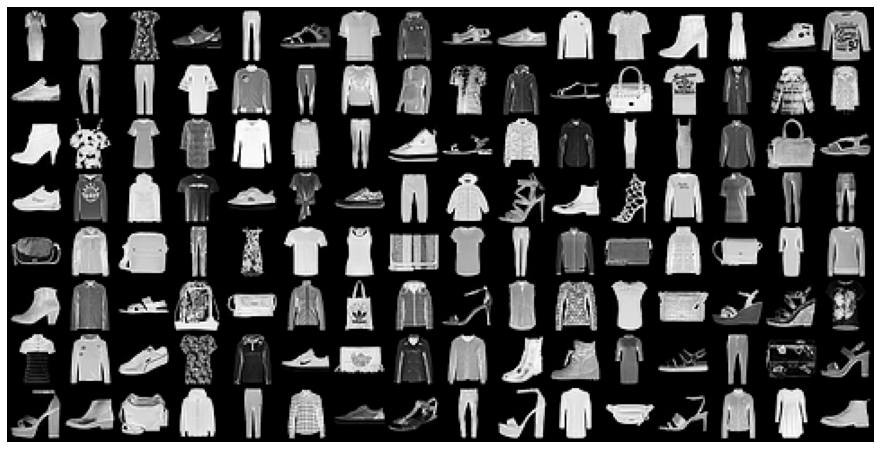

In [6]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Modelo

Podemos reaprovechar el código del ejercicio sobre MLP básico, con solo alguna variación en la clase que definirá el modelo. 

Los métodos y funciones auxiliares se aprovechan de forma directa

In [7]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [8]:
class MnistModel(nn.Module):
    """Red Neuronal con 2 capas ocultas"""
    def __init__(self, in_size, out_size):
        super().__init__()
        # hidden layer 1
        self.linear1 = nn.Linear(in_size, 16)
        # hidden layer 2
        self.linear2 = nn.Linear(16, 32)
        # output layer
        self.linear3 = nn.Linear(32, out_size)
        
    def forward(self, xb):
        # Extendemos los tensores de las imagenes (flatten)
        out = xb.view(xb.size(0), -1)
        # Salida inteermedia hidden layer 1
        out = self.linear1(out)
        # Aplicamos función de activación
        out = F.relu(out)
        #  Salida inteermedia hidden layer 2
        out = self.linear2(out)
        # Aplicamos función de activación
        out = F.relu(out)
        # Predicciones en la capa de salida
        out = self.linear3(out)
        return out

    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Genera predicciones
        loss = F.cross_entropy(out, labels) # Calcula loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Genera predicciones
        loss = F.cross_entropy(out, labels)   # Calcula loss
        acc = accuracy(out, labels)           # Calcula accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combina losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combina accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
  

## Usando una GPU

In [9]:
torch.cuda.is_available()

True

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [13]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

## Entrenamiento

In [15]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [16]:
input_size = 784
num_classes = 10

In [17]:
model = MnistModel(input_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=10, bias=True)
)

In [18]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.10048828274011612, 'val_loss': 2.3078815937042236}]

In [19]:
history += fit(10, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7916, val_acc: 0.6905
Epoch [1], val_loss: 0.6102, val_acc: 0.7628
Epoch [2], val_loss: 0.5816, val_acc: 0.7653
Epoch [3], val_loss: 0.4883, val_acc: 0.8262
Epoch [4], val_loss: 0.5122, val_acc: 0.8279
Epoch [5], val_loss: 0.5648, val_acc: 0.7972
Epoch [6], val_loss: 0.5123, val_acc: 0.8191
Epoch [7], val_loss: 0.4830, val_acc: 0.8276
Epoch [8], val_loss: 0.4391, val_acc: 0.8444
Epoch [9], val_loss: 0.4514, val_acc: 0.8401


In [20]:
history += fit(10, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.4082, val_acc: 0.8517
Epoch [1], val_loss: 0.4057, val_acc: 0.8538
Epoch [2], val_loss: 0.4032, val_acc: 0.8552
Epoch [3], val_loss: 0.4045, val_acc: 0.8536
Epoch [4], val_loss: 0.4013, val_acc: 0.8547
Epoch [5], val_loss: 0.4007, val_acc: 0.8597
Epoch [6], val_loss: 0.4042, val_acc: 0.8542
Epoch [7], val_loss: 0.4011, val_acc: 0.8547
Epoch [8], val_loss: 0.3972, val_acc: 0.8564
Epoch [9], val_loss: 0.3962, val_acc: 0.8588


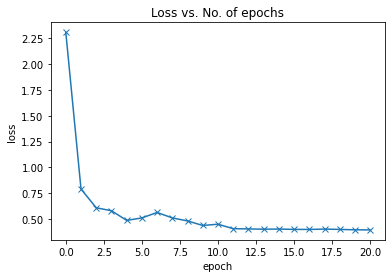

In [21]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

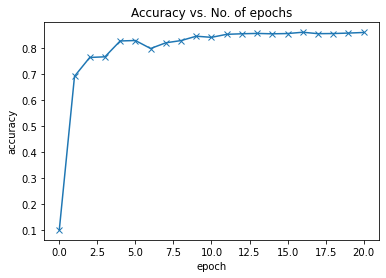

In [22]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [23]:
accuracies

[0.10048828274011612,
 0.6905273199081421,
 0.7627929449081421,
 0.765332043170929,
 0.826171875,
 0.827929675579071,
 0.797167956829071,
 0.819140613079071,
 0.82763671875,
 0.844433605670929,
 0.840136706829071,
 0.8516601324081421,
 0.853808581829071,
 0.855175793170929,
 0.8536132574081421,
 0.854687511920929,
 0.859667956829071,
 0.854199230670929,
 0.854687511920929,
 0.8564453125,
 0.8587890863418579]

## Prediccion con imágenes individuales

La función predict prepara los datos de entrada y devuelve el valor con más probabilidades de las 10 posibles salidas

In [24]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Probamos con varias imágenes:

Label: Coat , Predicted: Coat


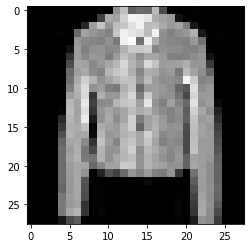

In [25]:
img, label = test_dataset[10]
plt.imshow(img[0], cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', dataset.classes[predict_image(img, model)])

Label: Pullover , Predicted: Coat


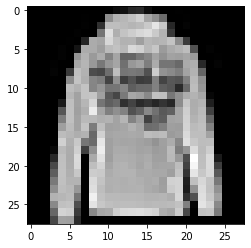

In [26]:
img, label = test_dataset[2020]
plt.imshow(img[0], cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', dataset.classes[predict_image(img, model)])

Label: T-shirt/top , Predicted: Shirt


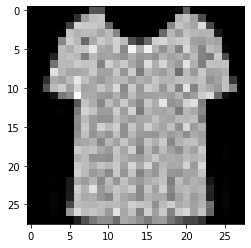

In [27]:
img, label = test_dataset[1000]
plt.imshow(img[0], cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', dataset.classes[predict_image(img, model)])

Evaluación sobre todo el conjunto de test

In [28]:
evaluate(model, test_loader)

{'val_acc': 0.85009765625, 'val_loss': 0.4133930206298828}

## Salvar el modelo


In [29]:
torch.save(model.state_dict(), 'mlp2-fashion.pth')

##Sugerencias para practicar

Intenta obtener mejores resultados. Para ello puedes probar cambiar algunos de los parámetros que hemos configurado a lo largo del Notebook: 

* Nº de neuronas por capas
* Tamaño de lote
* Nº de epochs de entrenamiento
* Tasa de aprendizaje
* Cantidad de capas ocultas. Esto es **deep learning!** añade nuevas capas


**NOTA:** Es posible llegar al 90% sin grandes dificultades.


## Fin del Notebook

Referencias y modelos empleados para el Notebook: 

*   Documentación de [Pytorch](https://pytorch.org/docs/stable/index.html) 
*   [PyTorch Tutorial for Deep Learning Researchers](https://github.com/yunjey/pytorch-tutorial) by Yunjey Choi
*   [FastAI](https://www.fast.ai/) development notebooks by Jeremy Howard.
*   Documentación y cursos en [Pierian Data](https://www.pieriandata.com/)
*   Tutoriales y notebooks del curso "Deep Learning with Pytorch: Zero to GANs" de [Aakash N S](https://jovian.ai/aakashns)
* [A visual proof that neural networks can compute any function](http://neuralnetworksanddeeplearning.com/chap4.html), también conocido como Teorema de Aproximación Universal
* [But what *is* a neural network?](https://www.youtube.com/watch?v=aircAruvnKk) - Una introducción muy intuitiva a lo que son las redes neuronales y lo que implican las capas ocultas.